<a href="https://colab.research.google.com/github/hypnopump/egnn-pytorch/blob/main/examples/egnn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get env ready

In [1]:
!pip install sidechainnet proDy einops
!git clone https://github.com/hypnopump/egnn-pytorch
!git clone https://github.com/hypnopump/geometric-vector-perceptron
!nvidia-smi

     |████████████████████████████████| 46.9MB 67kB/s 
     |████████████████████████████████| 6.3MB 19.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3MB 46.5MB/s 
  Created wheel for proDy: filename=ProDy-2.0-cp37-cp37m-linux_x86_64.whl size=6653588 sha256=278390d422375b81aa2ce5dc866266347376d995d0a02fa3cbe6b5e061043c7d
  Stored in directory: /root/.cache/pip/wheels/e2/be/52/a879e8adf713065f8f11e15c56073b311e82ecc85bbeb8b6c4
Successfully built proDy
Cloning into 'egnn-pytorch'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 474 (delta 110), reused 166 (delta 71), pack-reused 251
Receiving objects: 100% (474/474), 792.23 KiB | 13.66 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Cloning into 'geometric-vector-perceptron'...
remote: Enumerating obj

In [2]:
import torch
torch.__version__

'1.8.0+cu101'

In [3]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 2.6MB 29.6MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.5MB 29.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.0MB 25.1MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 389kB 29.8MB/s 
     |████████████████████████████████| 194kB 19.1MB/s 
     |████████████████████████████████| 235kB 44.1MB/s 
     |████████████████████████████████| 2.2MB 52.8MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp37-none-any.whl size=322719 sha256=74b4aa5dc627dddf2d081cc74921e011af6f9aeef48fe1637d0b53387fd43fa6
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011

In [4]:
# get CASP7 data copied from drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!mkdir sidechainnet_data
!cp drive/MyDrive/sidechainnet_casp7_30.pkl sidechainnet_data/sidechainnet_casp7_30.pkl

## Start code

### Load model and data

In [6]:
import os
import sys
import time

sys.path.append("geometric-vector-perceptron/geometric_vector_perceptron")
sys.path.append("geometric-vector-perceptron/examples")
sys.path.append("egnn-pytorch/egnn_pytorch")

In [22]:
import torch
import torch_sparse
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# custom model
from egnn_pytorch import *
from geometric_vector_perceptron import *
# custom utils
from data_handler import *
from data_utils import *
# process and dataset
import gc
import joblib
from tqdm import tqdm
from functools import partial

In [8]:
# data
import sidechainnet
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

@> ProDy is configured: verbosity='none'


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cpu")

In [10]:
# MIN_LEN = 70
MAX_LEN = 100000
MIN_LEN = 1000
MAX_PROTS = 360

In [11]:
# check dataloader works
dataloaders_ = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders_.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
train_examples_storer = [get_prot(dataloader_=dataloaders_, vocab_=VOCAB,
                                  min_len=MIN_LEN, max_len=MAX_LEN, verbose=0)\
                         for i in tqdm(range(3))]

# dataloaders won't work on my windows (idk why, so load examples from disk and train)
# train_examples_storer = joblib.load("sidechainnet_data/800_under_200.joblib"

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


100%|██████████| 3/3 [00:18<00:00,  6.10s/it]


### Custom data loader for egnn

In [42]:
# overwrite GVP function by this one - faster
def encode_whole_protein(seq, true_coords, padding_seq,
                         needed_info = { "cutoffs": [2, 5, 10],
                                          "bond_scales": [0.5, 1, 2]}, free_mem=False):
    """ Encodes a whole protein. In points + vectors. """
    device, precise = true_coords.device, true_coords.type()
    #################
    # encode points #
    #################
    cloud_mask = torch.tensor(scn_cloud_mask(seq[:-padding_seq or None])).bool().to(device)
    flat_mask = rearrange(cloud_mask, 'l c -> (l c)')
    coords_wrap = rearrange(true_coords, '(l c) d -> l c d', c=14)[:-padding_seq or None] 
    # embedd everything

    # position in backbone embedding
    aa_pos = encode_dist( torch.arange(len(seq[:-padding_seq or None]), device=device).float(), scales=needed_info["aa_pos_scales"])
    atom_pos = chain2atoms(aa_pos)[cloud_mask]

    # atom identity embedding
    atom_id_embedds = torch.stack([SUPREME_INFO[k]["atom_id_embedd"] for k in seq[:-padding_seq or None]], 
                                  dim=0)[cloud_mask].to(device)
    # aa embedding
    seq_int = torch.tensor([AAS2NUM[aa] for aa in seq[:-padding_seq or None]], device=device).long()
    aa_id_embedds   = chain2atoms(seq_int, mask=cloud_mask)

    ################
    # encode bonds #
    ################
    bond_info = encode_whole_bonds(x = coords_wrap[cloud_mask],
                                   x_format = "coords",
                                   embedd_info = {},
                                   needed_info = needed_info )
    whole_bond_idxs, whole_bond_enc, bond_embedd_info = bond_info
    #########
    # merge #
    #########

    # concat so that final is [vector_dims, scalar_dims]
    point_n_vectors = 0
    point_n_scalars = 2*len(needed_info["aa_pos_scales"]) + 1 +\
                      2 # the last 2 are to be embedded yet

    whole_point_enc = torch.cat([ atom_pos, # 2n+1
                                  atom_id_embedds.unsqueeze(-1),
                                  aa_id_embedds.unsqueeze(-1) ], dim=-1) # the last 2 are yet to be embedded
    if free_mem:
        del cloud_mask, atom_pos, atom_id_embedds, aa_id_embedds

    # record embedding dimensions
    point_embedd_info = {"point_n_vectors": point_n_vectors,
                         "point_n_scalars": point_n_scalars,}

    embedd_info = {**point_embedd_info, **bond_embedd_info}

    return whole_point_enc, whole_bond_idxs, whole_bond_enc, embedd_info

In [37]:
NEEDED_INFO = {"cutoffs": [], # "15_closest"
               "bond_scales": [1, 2],
               "aa_pos_scales": [2,4,8,16,32,64,128],
               "atom_pos_scales": [1,2,4,8,16,32],
               "dist2ca_norm_scales": [1,2,4],
               "bb_norms_atoms": [0.5], # will encode 3 vectors with this
               # nn-degree connection
               "adj_degree": 2
              }
# get model sizes from encoded protein
seq, true_coords, angles, padding_seq, mask, id = train_examples_storer[-1] 
NEEDED_INFO["seq"] = seq[:-padding_seq or None]
NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)


# encode as needed
encoded = encode_whole_protein(seq, true_coords, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
x, edge_index, edge_attrs, embedd_info = encoded
# add position coords
cloud_mask = scn_cloud_mask(seq)
if padding_seq:
    cloud_mask[-padding_seq:] = 0.
cloud_mask = cloud_mask.bool()
flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')

x = torch.cat( [ true_coords[flat_cloud_mask], x ], dim=-1 )

### adjust for egnn: 
embedd_info["bond_n_scalars"] -= 2*len(NEEDED_INFO["bond_scales"])+1
embedd_info["bond_n_vectors"] = 0
embedd_info

-0.0007340908050537109 done pre
0.001901388168334961 done atom_pos
0.0012786388397216797 done atom_id and aa_id
incise
0.09421181678771973 passed native
0.0055789947509765625 passed distance calc
stop incise
0.10299539566040039 done bond info


{'bond_embedding_nums': [2],
 'bond_n_scalars': 1,
 'bond_n_vectors': 0,
 'point_n_scalars': 17,
 'point_n_vectors': 0}

### Train

In [47]:
# define model
model = EGNN_Sparse_Network(n_layers=4,
                            feats_dim=2, pos_dim = 3,
                            edge_attr_dim = 1, m_dim = 32,
                            fourier_features = 4,
                            embedding_nums=[36,20], embedding_dims=[16,16],
                            edge_embedding_nums=[3], edge_embedding_dims=[2],
                            update_coors=True, update_feats=True, 
                            norm_feats=False, norm_coors=False, recalc=False)

In [48]:
model = model.to(device) # .double()

In [49]:
noise = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [50]:
model.train()

# info records
baseline_losses = []
epoch_losses    = []
tac    = time.time()
# training run params
max_seq_len = MAX_LEN # 120
iteration   = 0
n_per_iter  = MAX_PROTS # 400
for ep in range( 100 ): # 1*n_per_iter
    # delete useless data from prev iter - but not in last one
    if ep > 0:
        del true_coords, angles, edge_index, edge_attrs
        del target_coords, pred_coords, base_coords
        del encoded, target_aligned, pred_aligned
        gc.collect()
        
        
    # get model sizes from encoded protein
    seq, true_coords, angles, padding_seq, mask, pid = get_prot(dataloader_=dataloaders_,
                                                           vocab_=VOCAB, 
                                                           min_len=500,
                                                           max_len=MAX_LEN, 
                                                           verbose=0)
    NEEDED_INFO["seq"] = seq[:-padding_seq or None]
    NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)
        
    # pass to device
    true_coords = true_coords.to(device) # .double()
    angles = angles.to(device)           # .double()

    # encode as needed
    masked_coords = true_coords + noise * torch.randn_like(true_coords) # (*2-1)
    encoded = encode_whole_protein(seq, true_coords, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
    x, edge_index, edge_attrs, embedd_info = encoded
    # add position coords - better mask accounting for missing atoms
    cloud_mask_naive = scn_cloud_mask(seq).bool()
    cloud_mask = scn_cloud_mask(seq, coords=true_coords).bool()
    if padding_seq:
      cloud_mask[-padding_seq:] = 0.
    # cloud is all points, chain is all for which we have labels
    chain_mask = mask.unsqueeze(-1) * cloud_mask
    flat_chain_mask = rearrange(chain_mask, 'l c -> (l c)')
    flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')
    # slice useless norm and vector embeddings
    masked_coords = masked_coords[flat_cloud_mask]

    #############
    # MASK EDGES AND NODES ACCOUNTING FOR SCN MISSING ATOMS
    #############
    # NODES
    x = torch.cat( [ masked_coords, x[:, -2:][cloud_mask[cloud_mask_naive]] ], dim=-1 )
    # EDGES: delete all edges with masked-out atoms

    # pick all current indexes and turn them to 1.
    to_mask_edges = torch.zeros(edge_index.amax()+1, edge_index.amax()+1).to(edge_index.device)
    to_mask_edges[edge_index[0], edge_index[1]] = 1.
    # delete erased bonds
    masked_out_atoms = (-1*(cloud_mask[cloud_mask_naive].float() - 1)).bool()
    to_mask_edges[masked_out_atoms] *= 0.
    to_mask_edges = to_mask_edges * to_mask_edges.t()
    # get mask for the edge_attrs
    attr_mask = to_mask_edges[edge_index[0], edge_index[1]].bool()
    edge_attrs = edge_attrs[attr_mask, :]
    # delete unwanted rows and cols
    wanted = to_mask_edges.sum(dim=-1).bool()
    edge_index = (to_mask_edges[wanted, :][:, wanted]).nonzero().t()
    #############
    # continue
    #############
    edge_attrs = edge_attrs[:, -1:]
    batch = torch.tensor([0 for i in range(x.shape[0])], device=device).long()
    
    if torch.amax(edge_index) >= x.shape[0]:
      print("wtf, breaking, debug, index out of bounds")
      break

    # predict
    preds = model.forward(x, edge_index, batch=batch, edge_attr=edge_attrs,
                          recalc_edge=None, verbose = False)
    
    # MEASURE ERROR - format pred and target
    target_coords = true_coords[flat_cloud_mask].clone()
    pred_coords   = preds[:, :3]
    base_coords   = x[:, :3]
    
    # option 2: loss is RMSD on reconstructed coords  // align - sometimes svc fails - idk why
    try:
        pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)

        loss = ( (pred_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean() 
    except:
        pred_aligned, target_aligned = None, None
        print("svd failed convergence, ep:", ep)
        loss = ( (pred_coords - target_coords)[flat_chain_mask[flat_cloud_mask]]**2 ).mean()
    # measure error
    loss_base = ((base_coords - target_coords)**2).mean() 
    # not aligned: # loss = ((pred_coords - target_coords)**2).mean()**0.5 
    
    # back pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # records / prints
    iteration += 1
    epoch_losses.append( loss.item() )
    baseline_losses.append( loss_base.item() )

    n_print = 10
    if iteration % n_print == 1:
        tic = time.time()
        print("BATCH: {0} / {1}, loss: {2}, baseline_loss: {3}, time: {4}".format(iteration, n_per_iter,
                                                                                  np.mean(epoch_losses[-n_print:]),
                                                                                  baseline_losses[-1],
                                                                                  tic-tac))
        tac = time.time()
        if iteration % n_per_iter == 1:
            print("---------------------------------")


BATCH: 1 / 360, loss: 2.5847725868225098, baseline_loss: 0.9966086149215698, time: 1.3388707637786865
---------------------------------
BATCH: 11 / 360, loss: 0.3536249419674277, baseline_loss: 0.9887946844100952, time: 19.92944622039795
BATCH: 21 / 360, loss: 0.36209836415946484, baseline_loss: 1.0043601989746094, time: 17.99134874343872
BATCH: 31 / 360, loss: 0.344605815410614, baseline_loss: 0.9890645742416382, time: 21.275055170059204
BATCH: 41 / 360, loss: 0.26365440897643566, baseline_loss: 1.0025755167007446, time: 23.56508207321167
BATCH: 51 / 360, loss: 0.27823740243911743, baseline_loss: 1.0097358226776123, time: 22.355546236038208
BATCH: 61 / 360, loss: 0.20594989992678164, baseline_loss: 1.011623740196228, time: 24.13818669319153
BATCH: 71 / 360, loss: 0.3695221461355686, baseline_loss: 0.97552490234375, time: 21.30801749229431
BATCH: 81 / 360, loss: 0.18809853680431843, baseline_loss: 1.013718605041504, time: 21.707374334335327
BATCH: 91 / 360, loss: 0.4093939319252968, ba

In [51]:
# expected loss without denoising - recorded inside training loop
np.mean(baseline_losses) 

1.0022651320695877

### Train plot

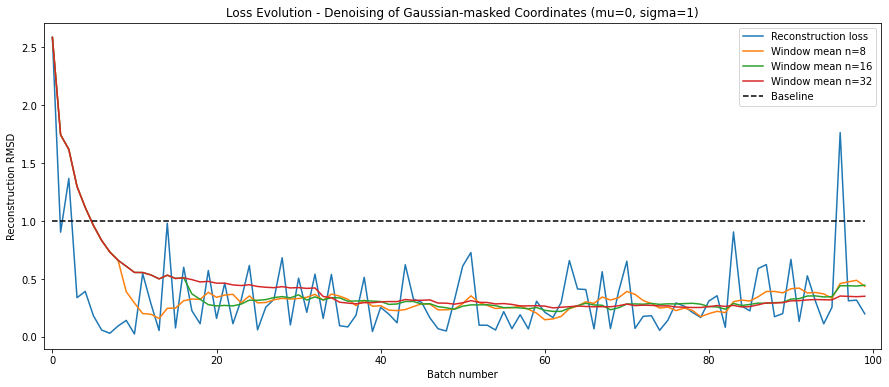

In [52]:
plt.figure(figsize=(15,6))
plt.title("Loss Evolution - Denoising of Gaussian-masked Coordinates (mu=0, sigma=1)")
plt.plot(epoch_losses, label="Reconstruction loss")

for window in [8,16,32]:
    plt.plot([np.mean(epoch_losses[:window][0:i+1]) for i in range(min(window, len(epoch_losses))) ] + \
             [np.mean(epoch_losses[i:i+window+1]) for i in range(len(epoch_losses)-window)], 
             label="Window mean n={0}".format(window))

plt.plot(np.ones(len(epoch_losses)) * np.mean(baseline_losses), "k--", label="Baseline")
    
# plt.yscale("log")
plt.xlim(-0.01*len(epoch_losses),1.01*len(epoch_losses))
# plt.yscale("log")
plt.ylabel("Reconstruction RMSD")
plt.xlabel("Batch number")
plt.legend()
plt.show()

In [53]:
print("MSE between masked coords: ", ((base_coords - target_coords)**2).mean() )

MSE between masked coords:  tensor(0.9803, device='cuda:0')


In [54]:
# rotate / align
pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)
print("MSE between reconstructed coords: ", ((pred_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2).mean() )

MSE between reconstructed coords:  tensor(0.1991, device='cuda:0', grad_fn=<MeanBackward0>)


### Protein plots

In [61]:
scaffs  = {"cloud_mask": scn_cloud_mask(seq[:-padding_seq or None]).bool()}
wrapper = torch.zeros(*scaffs["cloud_mask"].shape, 3).cpu()
# rebuild target
target_rebuilt = wrapper.clone()
target_rebuilt[scaffs["cloud_mask"].cpu()] = target_aligned.t().cpu()
# rebuild encoded-decoded
pre_target_rebuilt = wrapper.clone()
pre_target_rebuilt[scaffs["cloud_mask"].cpu()] = target_aligned.t().cpu()
# build input coords (w/out sidechain)
input_rebuilt = wrapper.clone()
input_rebuilt[scaffs["cloud_mask"].cpu()] = base_coords.cpu()
# build predicted
pred_rebuilt = wrapper.clone()
pred_rebuilt[scaffs["cloud_mask"].cpu()] = pred_aligned.t().cpu()

In [57]:
# label
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq or None]]),
                                    crd=rearrange(pre_target_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [58]:
# label
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq or None]]),
                                    crd=rearrange(input_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [59]:
# reconstructed
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq or None]]),
                                    crd=rearrange(input_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Addendum (not used)

In [43]:
def encode_whole_bonds(x, x_format="coords", embedd_info={},
                       needed_info = {"cutoffs": [2,5,10],
                                      "bond_scales": [.5, 1, 2],
                                      "adj_degree": 1},
                       free_mem=False, eps=1e-7):
    """ Given some coordinates, and the needed info,
        encodes the bonds from point information.
        * x: (N, 3) or prediction format
        * x_format: one of ["coords" or "prediction"]
        * embedd_info: dict. contains the needed embedding info
        * needed_info: dict. contains additional needed info
            { cutoffs: list. cutoff distances for bonds.
                       can be a string for the k closest (ex: "30_closest"),
                       empty list for just covalent.
              bond_scales: list. fourier encodings
              adj_degree: int. degree of adj (2 means adj of adj is my adj)
                               0 for no adjacency
            }
        * free_mem: whether to delete variables
        * eps: constant for numerical stability
    """ 
    device, precise = x.device, x.type()
    # convert to 3d coords if passed as preds
    if x_format == "encode":
        pred_x = from_encode_to_pred(x, embedd_info=embedd_info, needed_info=needed_info)
        x = pred_x[:, :3] * pred_x[:, 3:4]

    # encode bonds

    # 1. BONDS: find the covalent bond_indices - allow arg -> DRY
    native = None
    if "prot_covalent_bond" in needed_info.keys():
        native = True
        native_bonds = needed_info["covalent_bond"]
    elif needed_info["adj_degree"]:
        native = True
        native_bonds  = prot_covalent_bond(needed_info["seq"], needed_info["adj_degree"])
        
    if native: 
        native_idxs, native_attrs = native_bonds[0].to(device), native_bonds[1].to(device)
    
    # determine kind of cutoff (hard distance threhsold or closest points)
    closest = None
    if len(needed_info["cutoffs"]) > 0: 
        cutoffs = needed_info["cutoffs"].copy() 
        if sum( isinstance(ci, str) for ci in cutoffs ) > 0:
            cutoffs = [-1e-3] # negative so no bond is taken  
            closest = int( needed_info["cutoffs"][0].split("_")[0] ) 

        # points under cutoff = d(i - j) < X 
        cutoffs = torch.tensor(cutoffs, device=device).type(precise)
        dist_mat = torch.cdist(x, x, p=2)

    # normal buckets
    bond_buckets = torch.zeros(*x.shape[:-1], x.shape[-2], device=device).type(precise)
    if len(needed_info["cutoffs"]) > 0 and not closest:
        # count from latest degree of adjacency given
        bond_buckets = torch.bucketize(dist_mat, cutoffs)
        bond_buckets[native_idxs[0], native_idxs[1]] = cutoffs.shape[0]
        # find the indexes - symmetric and we dont want the diag
        bond_buckets   += cutoffs.shape[0] * torch.eye(bond_buckets.shape[0], device=device).long()
        close_bond_idxs = ( bond_buckets < cutoffs.shape[0] ).nonzero().t()
        # move away from poses reserved for native
        bond_buckets[close_bond_idxs[0], close_bond_idxs[1]] += needed_info["adj_degree"]+1

    # the K closest (covalent bonds excluded) are considered bonds 
    elif closest:
        k = closest
        # copy dist_mat and mask the covalent bonds out
        masked_dist_mat = dist_mat.clone()
        masked_dist_mat += torch.eye(masked_dist_mat.shape[0], device=device) * torch.amax(masked_dist_mat)
        masked_dist_mat[native_idxs[0], native_idxs[1]] = masked_dist_mat[0,0].clone()
        # argsort by distance || *(-1) so min is first
        _, sorted_col_idxs = torch.topk(-masked_dist_mat, k=k, dim=-1)
        # cat idxs and repeat row idx to match number of column idx
        sorted_col_idxs = rearrange(sorted_col_idxs[:, :k], '... n k -> ... (n k)')
        sorted_row_idxs = torch.repeat_interleave( torch.arange(dist_mat.shape[0]).long(), repeats=k ).to(device)
        close_bond_idxs = torch.stack([ sorted_row_idxs, sorted_col_idxs ], dim=0)
        # move away from poses reserved for native
        bond_buckets = torch.ones_like(dist_mat) * (needed_info["adj_degree"]+1)

    # merge all bonds
    if len(needed_info["cutoffs"]) > 0:
        if close_bond_idxs.shape[0] > 0:
            whole_bond_idxs = torch.cat([native_idxs, close_bond_idxs], dim=-1)
    else:
        whole_bond_idxs = native_idxs

    # 2. ATTRS: encode bond -> attrs
    bond_vecs  = x[ whole_bond_idxs[0] ] - x[ whole_bond_idxs[1] ]
    bond_norms = torch.norm(bond_vecs, dim=-1)
    bond_vecs /= (bond_norms + eps).unsqueeze(-1)
    bond_norms_enc = encode_dist(bond_norms, scales=needed_info["bond_scales"]).squeeze()

    if native:
        bond_buckets[native_idxs[0], native_idxs[1]] = native_attrs
    bond_attrs = bond_buckets[whole_bond_idxs[0] , whole_bond_idxs[1]]
    # pack scalars and vectors - extra token for covalent bonds
    bond_n_vectors = 1
    bond_n_scalars = (2 * len(needed_info["bond_scales"]) + 1) + 1 # last one is an embedd of size 1+len(cutoffs)
    whole_bond_enc = torch.cat([bond_vecs, # 1 vector - no need of reverse - we do 2x bonds (symmetry)
                                # scalars
                                bond_norms_enc, # 2 * len(scales)
                                (bond_attrs-1).unsqueeze(-1) # 1 
                               ], dim=-1) 
    # free gpu mem
    if free_mem:
        del bond_buckets, bond_norms_enc, bond_vecs, dist_mat,\
            close_bond_idxs, native_bond_idxs
        if closest: 
            del masked_dist_mat, sorted_col_idxs, sorted_row_idxs

    embedd_info = {"bond_n_vectors": bond_n_vectors, 
                   "bond_n_scalars": bond_n_scalars, 
                   "bond_embedding_nums": [ len(needed_info["cutoffs"]) + needed_info["adj_degree"] ]} # extra one for covalent (default)

    return whole_bond_idxs, whole_bond_enc, embedd_info

In [44]:
def prot_covalent_bond(seq, adj_degree=1, cloud_mask=None):
    """ Returns the idxs of covalent bonds for a protein.
        Inputs 
        * seq: str. Protein sequence in 1-letter AA code.
        * cloud_mask: mask selecting the present atoms.
        Outputs: edge_idxs
    """
    # create or infer cloud_mask
    if cloud_mask is None: 
        cloud_mask = scn_cloud_mask(seq).bool()
    device, precise = cloud_mask.device, cloud_mask.type()
    # get starting poses for every aa
    scaff = torch.zeros_like(cloud_mask)
    scaff[:, 0] = 1
    idxs = scaff[cloud_mask].nonzero().view(-1)
    # get poses + idxs from the dict with GVP_DATA - return all edges
    adj_mat = torch.zeros(idxs.amax()+14, idxs.amax()+14)
    attr_mat = torch.zeros_like(adj_mat)
    for i,idx in enumerate(idxs):
        # bond with next aa
        extra = []
        if i < idxs.shape[0]-1:
            extra = [[2, (idxs[i+1]-idx).item()]]

        bonds = idx + torch.tensor( GVP_DATA[seq[i]]['bonds'] + extra ).long().t() 
        adj_mat[bonds[0], bonds[1]] = 1.

    # convert to undirected
    adj_mat = adj_mat + adj_mat.t()
    # do N_th degree adjacency
    for i in range(adj_degree):
        if i == 0:
            attr_mat += adj_mat
            continue

        adj_mat = (adj_mat @ adj_mat).bool().float() 
        attr_mat[ (adj_mat - attr_mat.bool().float()).bool() ] += i+1

    edge_idxs = attr_mat.nonzero().t().long()
    edge_attrs = attr_mat[edge_idxs[0], edge_idxs[1]]

    return edge_idxs, edge_attrs

In [45]:
def nth_deg_adjacency(adj_mat, n=1, sparse=True):
    """ Calculates the n-th degree adjacency matrix.
        Performs mm of adj_mat and adds the newly added.
        Default is dense. Mods for sparse version are done when needed.
        Inputs: 
        * adj_mat: (N, N) adjacency tensor
        * n: int. degree of the output adjacency
        * sparse: bool. whether to use torch-sparse module
        Outputs: 
        * edge_idxs: the ij positions of the adjacency matrix
        * edge_attrs: the degree of connectivity (1 for neighs, 2 for neighs^2 )
    """
    adj_mat = adj_mat.float()
    attr_mat = torch.zeros_like(adj_mat)
        
    for i in range(n):
        if i == 0:
            attr_mat += adj_mat
            continue

        if i == 1 and sparse: 
            # create sparse adj tensor
            adj_mat = torch.sparse.FloatTensor( adj_mat.nonzero().t(),
                                                adj_mat[ adj_mat!=0 ] ).to(adj_mat.device).coalesce()
            idxs, vals = adj_mat.indices(), adj_mat.values()
            m, k, n = 3 * [adj_mat.shape[0]] # (m, n) * (n, k) , but adj_mats are squared: m=n=k

        if sparse:
            idxs, vals = torch_sparse.spspmm(idxs, vals, idxs, vals, m=m, k=k, n=n)
            adj_mat = torch.zeros_like(attr_mat)
            adj_mat[idxs[0], idxs[1]] = vals.bool().float()
        else:
            adj_mat = (adj_mat @ adj_mat).bool().float() 

        attr_mat[ (adj_mat - attr_mat.bool().float()).bool() ] += i+1

    return adj_mat, attr_mat

def prot_covalent_bond(seq, adj_degree=1, cloud_mask=None):
    """ Returns the idxs of covalent bonds for a protein.
        Inputs 
        * seq: str. Protein sequence in 1-letter AA code.
        * cloud_mask: mask selecting the present atoms.
        Outputs: edge_idxs
    """
    # create or infer cloud_mask
    if cloud_mask is None: 
        cloud_mask = scn_cloud_mask(seq).bool()
    device, precise = cloud_mask.device, cloud_mask.type()
    # get starting poses for every aa
    scaff = torch.zeros_like(cloud_mask)
    scaff[:, 0] = 1
    idxs = scaff[cloud_mask].nonzero().view(-1)
    # get poses + idxs from the dict with GVP_DATA - return all edges
    adj_mat = torch.zeros(idxs.amax()+14, idxs.amax()+14)
    for i,idx in enumerate(idxs):
        # bond with next aa
        extra = []
        if i < idxs.shape[0]-1:
            extra = [[2, (idxs[i+1]-idx).item()]]

        bonds = idx + torch.tensor( GVP_DATA[seq[i]]['bonds'] + extra ).long().t() 
        adj_mat[bonds[0], bonds[1]] = 1.
    # convert to undirected
    adj_mat = adj_mat + adj_mat.t()
    # do N_th degree adjacency
    adj_mat, attr_mat = nth_deg_adjacency(adj_mat, n=adj_degree, sparse=True)

    edge_idxs = attr_mat.nonzero().t().long()
    edge_attrs = attr_mat[edge_idxs[0], edge_idxs[1]]
    return edge_idxs, edge_attrs